# Ray et al 2013 Evaluation
**Authorship:**
Adam Klie, *08/31/2022*
***
**Description:**
Notebook to evaluate trained models on the Ray et al dataset.
***

In [1]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import glob
import logging
import torch
import numpy as np
import pandas as pd
import eugene as eu
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:36: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/mnt/beegfs/users/aklie/projects/EUGENe/eugene/external/kipoi_veff/seqplotting_deps.py:37: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


Already up to date.


In [51]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene/ray13"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/ray13"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/ray13"
eu.settings.config_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/configs/ray13"
figure_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/figures/ray13"
eu.settings.verbosity = logging.ERROR
number_kmers = 10

# Load in the test `SeqData`

In [3]:
# Load the test data
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, "norm_setB_processed_ST.h5sd"))
target_mask = sdata_test.seqs_annot.columns.str.contains("RNCMPT")
target_cols = sdata_test.seqs_annot.columns[target_mask]
sdata_test

SeqData object with = 121031 seqs
seqs = (121031,)
names = (121031,)
rev_seqs = None
ohe_seqs = (121031, 41, 4)
ohe_rev_seqs = None
seqs_annot: 'Probe_Set', 'RNCMPT00001', 'RNCMPT00002', 'RNCMPT00003', 'RNCMPT00004', 'RNCMPT00005', 'RNCMPT00006', 'RNCMPT00007', 'RNCMPT00008', 'RNCMPT00009', 'RNCMPT00010', 'RNCMPT00011', 'RNCMPT00012', 'RNCMPT00013', 'RNCMPT00014', 'RNCMPT00015', 'RNCMPT00016', 'RNCMPT00017', 'RNCMPT00018', 'RNCMPT00019', 'RNCMPT00020', 'RNCMPT00021', 'RNCMPT00022', 'RNCMPT00023', 'RNCMPT00024', 'RNCMPT00025', 'RNCMPT00026', 'RNCMPT00027', 'RNCMPT00028', 'RNCMPT00029', 'RNCMPT00031', 'RNCMPT00032', 'RNCMPT00033', 'RNCMPT00034', 'RNCMPT00035', 'RNCMPT00036', 'RNCMPT00037', 'RNCMPT00038', 'RNCMPT00039', 'RNCMPT00040', 'RNCMPT00041', 'RNCMPT00042', 'RNCMPT00043', 'RNCMPT00044', 'RNCMPT00045', 'RNCMPT00046', 'RNCMPT00047', 'RNCMPT00049', 'RNCMPT00050', 'RNCMPT00051', 'RNCMPT00052', 'RNCMPT00053', 'RNCMPT00054', 'RNCMPT00055', 'RNCMPT00056', 'RNCMPT00057', 'RNCMPT00058', 'RN

In [5]:
# Load in the Set B presence/absence predictions
b_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "setB_binary.npy"))
setB_observed = sdata_test.seqs_annot[target_cols]

# Get test set evaluations for each model

## SetA k-mer scores 

In [7]:
# Load in the Set A presence/absence predictions
a_presence_absence = np.load(os.path.join(eu.settings.dataset_dir, "SetA_binary_ST.npy"))
setA_observed = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_processed_ST.h5sd")).seqs_annot[target_cols]

In [8]:
# An example calculation of z-scores, aucs and e-scores for Set A and Set B
a_metr = eu.predict.rna_complete_metrics_apply(a_presence_absence, setA_observed["RNCMPT00001"].values, verbose=True, num_kmers=100)
b_metr = eu.predict.rna_complete_metrics_apply(b_presence_absence, setB_observed["RNCMPT00001"].values, verbose=True, num_kmers=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
# Performing the above calculation for all targets (TODO: parallelize and simplify)
from scipy.stats import pearsonr, spearmanr
pearson_setA_long = pd.DataFrame()
spearman_setA_long = pd.DataFrame()
for i, task in tqdm(enumerate(target_cols[:3]), desc="Calcualting metrics on each task", total=len(target_cols)):
    a_zscores, a_aucs, a_escores  = eu.predict.rna_complete_metrics_apply(a_presence_absence, setA_observed[task].values, verbose=True, use_calc_auc=True, num_kmers=100)
    b_zscores, b_aucs, b_escores = eu.predict.rna_complete_metrics_apply(b_presence_absence, setB_observed[task].values, verbose=True, use_calc_auc=True, num_kmers=100) 
    
    zscore_nan_mask = np.isnan(a_zscores) | np.isnan(b_zscores)
    a_zscores = a_zscores[~zscore_nan_mask]
    b_zscores = b_zscores[~zscore_nan_mask]
    if len(a_zscores) > 0 and len(b_zscores) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Pearson": pearsonr(a_zscores, b_zscores)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "Z-score", "Spearman": spearmanr(a_zscores, b_zscores)[0]}), ignore_index=True)

    auc_nan_mask = np.isnan(a_aucs) | np.isnan(b_aucs)
    a_aucs = a_aucs[~auc_nan_mask]
    b_aucs = b_aucs[~auc_nan_mask]
    if len(a_aucs) > 0 and len(b_aucs) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Pearson": pearsonr(a_aucs, b_aucs)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "AUC", "Spearman": spearmanr(a_aucs, b_aucs)[0]}), ignore_index=True)
    
    escore_nan_mask = np.isnan(a_escores) | np.isnan(b_escores)
    a_escores = a_escores[~escore_nan_mask]
    b_escores = b_escores[~escore_nan_mask]
    if len(a_escores) > 0 and len(b_escores) > 0:
        pearson_setA_long = pearson_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Pearson": pearsonr(a_escores, b_escores)[0]}), ignore_index=True)
        spearman_setA_long = spearman_setA_long.append(pd.Series({"RBP": task, "Metric": "E-score", "Spearman": spearmanr(a_escores, b_escores)[0]}), ignore_index=True)

pearson_setA_long["Model"] = "SetA"
spearman_setA_long["Model"] = "SetA"

Calcualting metrics on each task:   0%|          | 0/244 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
# Memory cleanup
del a_presence_absence

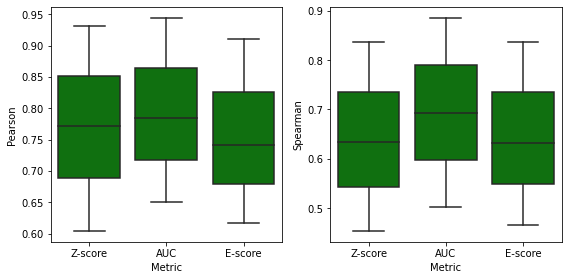

In [25]:
# Plot just the SetA results 
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_setA_long, x="Metric", y="Pearson", color="green", ax=ax[0])
sns.boxplot(data=spearman_setA_long, x="Metric", y="Spearman", color="green", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_setA.pdf"))

## Single-task model evaluation 

In [56]:
# Get predictions on the test data from all single task models
for i, target_col in enumerate(target_cols[:20]):
    print(f"Testing DeepBind SingleTask model on {target_col}")
    try:
        model_file = glob.glob(os.path.join(eu.settings.logging_dir, "DeepBind_ST", target_col, "checkpoints", "*"))[0]
        model = eu.models.DeepBind.load_from_checkpoint(model_file)
    except:
        print(f"No model trained for {target_col}")
        continue
    eu.settings.dl_num_workers = 0
    eu.predict.predictions(
        model,
        sdata=sdata_test, 
        target=target_col,
        name="DeepBind_ST",
        version=target_col,
        file_label="test",
        suffix="_ST"
    )
    del model

Testing DeepBind SingleTask model on RNCMPT00001
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00002
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00003
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00004
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00005
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

Testing DeepBind SingleTask model on RNCMPT00006
No model trained for RNCMPT00006
Testing DeepBind SingleTask model on RNCMPT00007
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00007_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00008
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00008_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00009
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00009_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00010
No model trained for RNCMPT00010
Testing DeepBind SingleTask model on RNCMPT00011
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00011_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00012
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00012_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00013
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00013_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00014
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00014_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00015
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00015_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00016
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00016_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00017
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00017_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00018
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00018_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00019
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00019_predictions_ST
Testing DeepBind SingleTask model on RNCMPT00020
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

SeqData object modified:
    seqs_annot:
        + RNCMPT00020_predictions_ST


In [29]:
# Get evaluation metrics for all single task models and format for plotting
pearson_ST_df, spearman_ST_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, target_cols[:3], use_calc_auc=True, verbose=True, n_kmers=100, preds_suffix="_predictions_ST")
pearson_ST_long = pearson_ST_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_ST_long = spearman_ST_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_ST_long["Model"] = "SingleTask"
spearman_ST_long["Model"] = "SingleTask"

Evaluating probes:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

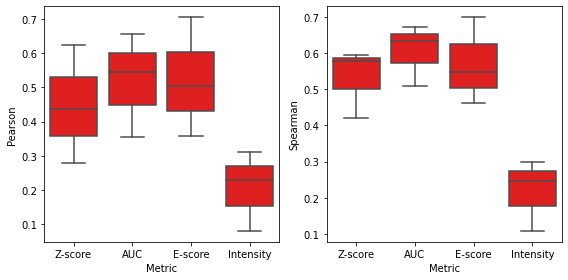

In [30]:
# Plot just the single task model eval
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_ST_long, x="Metric", y="Pearson", color="red", ax=ax[0])
sns.boxplot(data=spearman_ST_long, x="Metric", y="Spearman", color="red", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_ST.pdf"))

## Multitask model evaluation

In [35]:
# Also need the multi-task columns (single task we could train on all the columns)
sdata_training = eu.dl.read_h5sd(os.path.join(eu.settings.dataset_dir, eu.settings.dataset_dir, "norm_setA_sub_MT.h5sd"))
target_mask_MT = sdata_training.seqs_annot.columns.str.contains("RNCMPT")
target_cols_MT = sdata_training.seqs_annot.columns[target_mask_MT]
del sdata_training
len(target_cols_MT)

233

In [36]:
# Get predictions on the test data from all multi task models
print("Testing DeepBind MultiTask model on")
version = 0
model_file = glob.glob(os.path.join(eu.settings.logging_dir, "DeepBind_MT", f"v{version}", "checkpoints", "*"))[0]
model = eu.models.DeepBind.load_from_checkpoint(model_file)
eu.settings.dl_num_workers = 0
eu.predict.predictions(
    model,
    sdata=sdata_test, 
    target=target_cols_MT,
    name="DeepBind_MT",
    version=f"v{version}",
    file_label="test",
    suffix="_MT"
)
del model

Testing DeepBind MultiTask model on
No transforms given, assuming just need to tensorize).


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Predicting: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


SeqData object modified:
    seqs_annot:
        + RNCMPT00187_predictions_MT, RNCMPT00138_predictions_MT, RNCMPT00073_predictions_MT, RNCMPT00117_predictions_MT, RNCMPT00197_predictions_MT, RNCMPT00076_predictions_MT, RNCMPT00139_predictions_MT, RNCMPT00265_predictions_MT, RNCMPT00285_predictions_MT, RNCMPT00284_predictions_MT, RNCMPT00012_predictions_MT, RNCMPT00121_predictions_MT, RNCMPT00291_predictions_MT, RNCMPT00056_predictions_MT, RNCMPT00143_predictions_MT, RNCMPT00091_predictions_MT, RNCMPT00111_predictions_MT, RNCMPT00241_predictions_MT, RNCMPT00239_predictions_MT, RNCMPT00068_predictions_MT, RNCMPT00086_predictions_MT, RNCMPT00236_predictions_MT, RNCMPT00023_predictions_MT, RNCMPT00090_predictions_MT, RNCMPT00057_predictions_MT, RNCMPT00219_predictions_MT, RNCMPT00010_predictions_MT, RNCMPT00175_predictions_MT, RNCMPT00203_predictions_MT, RNCMPT00226_predictions_MT, RNCMPT00258_predictions_MT, RNCMPT00038_predictions_MT, RNCMPT00289_predictions_MT, RNCMPT00184_predictions_M

In [37]:
# Get evaluation metrics for all single task models and format for plotting
pearson_MT_df, spearman_MT_df = eu.predict.summarize_rbps_apply(sdata_test, b_presence_absence, target_cols_MT[:3], use_calc_auc=True, verbose=True, n_kmers=100, preds_suffix="_predictions_MT")
pearson_MT_long = pearson_MT_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_MT_long = spearman_MT_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_MT_long["Model"] = "MultiTask"
spearman_MT_long["Model"] = "MultiTask"

Evaluating probes:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

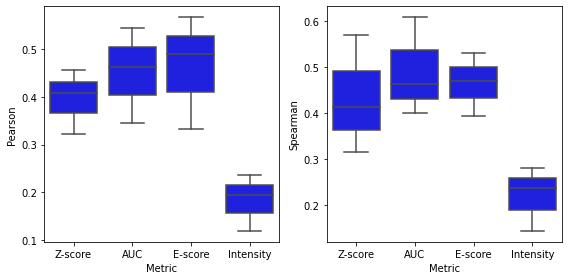

In [38]:
# Plot just the multi task model eval
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_MT_long, x="Metric", y="Pearson", color="blue", ax=ax[0])
sns.boxplot(data=spearman_MT_long, x="Metric", y="Spearman", color="blue", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_MT.pdf"))

## Kipoi models

In [6]:
# We need to get the protein IDs from the motifs in the
id_mapping = pd.read_excel(os.path.join(eu.settings.dataset_dir, "hg19_motif_hits", "ID.mapping.xls"), sheet_name=0)
id_mp = id_mapping.set_index("Motif ID")["Protein(s)"]
cols_w_ids = ~target_cols.map(id_mp).isna()
target_cols_w_ids = target_cols[cols_w_ids]
ids_w_target_cols = pd.Index([id.split("(")[0].rstrip() for id in target_cols_w_ids.map(id_mp)])

In [7]:
# Get the kipoi models names
db_model_names = eu.external.kipoi.get_model_names("DeepBind/Homo_sapiens/RBP/D")

In [13]:
# Get predictions with each model and store them in sdata
target_cols_w_model = []
for i, (protein_id , motif_id) in tqdm(enumerate(zip(ids_w_target_cols, target_cols_w_ids)), desc="Importing models", total=len(ids_w_target_cols)):
    print("Predicting for protein: ", protein_id, " motif: ", motif_id)
    db_model_name = db_model_names[db_model_names.str.contains(protein_id)]
    if len(db_model_name) == 0:
        print("No model found for protein: ", protein_id)
        continue
    try:
        model = eu.external.kipoi.get_model(db_model_name.values[0])
        sdata_test[f"{motif_id}_predictions_kipoi"] = model(sdata_test.ohe_seqs).cpu().numpy()
        target_cols_w_model.append(motif_id)
    except:
        print("Failed to load model")
    if len(target_cols_w_model) == 200:
        break

Importing models:   0%|          | 0/131 [00:00<?, ?it/s]

Predicting for protein:  A1CF  motif:  RNCMPT00001
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/arch/127f7597630be937c0495a27e6f42e5f
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d


2022-09-07 17:24:37.611552: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00084.001_RNAcompete_A1CF/weights/a4caf255312f44e3fd4e038a79691f2d: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  ANKHD1  motif:  RNCMPT00002
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00085.001_RNAcompete_ANKHD1/arch/4b6baf31fd2bcad82c936a536bea804c
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00085.001_RNAcompete_ANKHD1/weights/488b315616bdfaf723ea431bce2df302


2022-09-07 17:24:38.314824: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00085.001_RNAcompete_ANKHD1/weights/488b315616bdfaf723ea431bce2df302: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CELF4  motif:  RNCMPT00004
No model found for protein:  CELF4
Predicting for protein:  CNOT4  motif:  RNCMPT00008
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/arch/367bfbfebbe3deccfcee7247a6cf9de9
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/weights/cc7c64aa43e265a965b765db2cc044fe


2022-09-07 17:24:38.966238: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/weights/cc7c64aa43e265a965b765db2cc044fe: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CPEB2  motif:  RNCMPT00012
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/arch/c6a22ad58256249558a0de864debded3
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99


2022-09-07 17:24:39.869777: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  DAZAP1  motif:  RNCMPT00013
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1/arch/9d0289f968d184b4b4b11608c72b29ae
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1/weights/d5c4ab8e15825ceffb2eb928faf82c2e


2022-09-07 17:24:40.581181: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00096.001_RNAcompete_DAZAP1/weights/d5c4ab8e15825ceffb2eb928faf82c2e: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  FMR1  motif:  RNCMPT00016
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00099.001_RNAcompete_FMR1/arch/cb6cfce1c46c4a23288ebf5ed3a209ad
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00099.001_RNAcompete_FMR1/weights/a9341a78eb350065fb73c1917a94c83a


2022-09-07 17:24:41.287048: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00099.001_RNAcompete_FMR1/weights/a9341a78eb350065fb73c1917a94c83a: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBFOX1  motif:  RNCMPT00017
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/arch/dd107603901712c22dfeadcf9c0e58fd
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/weights/b1366c13b8973f8ef222e6effe105a15


2022-09-07 17:24:42.014345: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/weights/b1366c13b8973f8ef222e6effe105a15: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  BX511012.1  motif:  RNCMPT00019
No model found for protein:  BX511012.1
Predicting for protein:  FXR1  motif:  RNCMPT00020
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00206.001_RNAcompete_FXR1/arch/109afa6d9f1764d98e7bb9cfdb020a36
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00206.001_RNAcompete_FXR1/weights/f4b28111dafd71c8c555e1dbd991fc43


2022-09-07 17:24:42.723941: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00206.001_RNAcompete_FXR1/weights/f4b28111dafd71c8c555e1dbd991fc43: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  G3BP1  motif:  RNCMPT00021
No model found for protein:  G3BP1
Predicting for protein:  HNRNPA1  motif:  RNCMPT00022
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/arch/54630e5cb857f65cdc6c0ada7d998aa7
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/weights/dc0e0922078b87d91e98d46bd26551c4


2022-09-07 17:24:43.400133: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/weights/dc0e0922078b87d91e98d46bd26551c4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPA1  motif:  RNCMPT00023
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/arch/54630e5cb857f65cdc6c0ada7d998aa7
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/weights/dc0e0922078b87d91e98d46bd26551c4


2022-09-07 17:24:44.117495: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/weights/dc0e0922078b87d91e98d46bd26551c4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPA1  motif:  RNCMPT00024
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/arch/54630e5cb857f65cdc6c0ada7d998aa7
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/weights/dc0e0922078b87d91e98d46bd26551c4


2022-09-07 17:24:44.839014: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00105.001_RNAcompete_HNRNPA1/weights/dc0e0922078b87d91e98d46bd26551c4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPC  motif:  RNCMPT00025
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/arch/5c5934c57a3ddfa4df434a615144fa5c
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/weights/e195c591a2f3054a2746a12d0e149840


2022-09-07 17:24:45.560369: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/weights/e195c591a2f3054a2746a12d0e149840: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPK  motif:  RNCMPT00026
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00109.001_RNAcompete_HNRNPK/arch/561ff8b07948396720122a37dd3ed4a5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00109.001_RNAcompete_HNRNPK/weights/3a4ffb1a818ab0995619b831d2ad118d


2022-09-07 17:24:46.289778: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00109.001_RNAcompete_HNRNPK/weights/3a4ffb1a818ab0995619b831d2ad118d: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPL  motif:  RNCMPT00027
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00110.001_RNAcompete_HNRNPL/arch/d7c9f53d4bf8b0ad2ced3a994b92e4ac
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00110.001_RNAcompete_HNRNPL/weights/267c685c7097771f890437a4cca762fa


2022-09-07 17:24:47.004649: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00110.001_RNAcompete_HNRNPL/weights/267c685c7097771f890437a4cca762fa: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  ELAVL1  motif:  RNCMPT00032
No model found for protein:  ELAVL1
Predicting for protein:  IGF2BP1  motif:  RNCMPT00033
No model found for protein:  IGF2BP1
Predicting for protein:  KHDRBS1  motif:  RNCMPT00034
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/arch/5252ca72943dd4cc57d822c9ff7a796f
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/weights/fa3769dd6290c178a424ad3645e2b156


2022-09-07 17:24:47.714767: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/weights/fa3769dd6290c178a424ad3645e2b156: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  LIN28A  motif:  RNCMPT00036
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00118.001_RNAcompete_LIN28A/arch/2075f91bad7b3e34ca66d9855f753460
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00118.001_RNAcompete_LIN28A/weights/db03347dcfc00053f7ac236ef591a3ef


2022-09-07 17:24:48.456980: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00118.001_RNAcompete_LIN28A/weights/db03347dcfc00053f7ac236ef591a3ef: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  MATR3  motif:  RNCMPT00037
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00119.001_RNAcompete_MATR3/arch/8512f1da2508b25538c989d382085dc7
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00119.001_RNAcompete_MATR3/weights/19e642cb19f6ebc5ccdb01c09fbd83a0


2022-09-07 17:24:49.171048: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00119.001_RNAcompete_MATR3/weights/19e642cb19f6ebc5ccdb01c09fbd83a0: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  MBNL1  motif:  RNCMPT00038
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00120.001_RNAcompete_MBNL1/arch/3c106f20a0df32cb9cb80c980cf09aa1
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00120.001_RNAcompete_MBNL1/weights/0595e728c47fd92c23f85b92bf8c878e


2022-09-07 17:24:49.900052: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00120.001_RNAcompete_MBNL1/weights/0595e728c47fd92c23f85b92bf8c878e: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  MSI1  motif:  RNCMPT00041
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00123.001_RNAcompete_MSI1/arch/625b2c5ff8c457febe0fc5fecea4ae94
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00123.001_RNAcompete_MSI1/weights/c189b586fe9a9b98192144a86e4f8d6b


2022-09-07 17:24:50.624121: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00123.001_RNAcompete_MSI1/weights/c189b586fe9a9b98192144a86e4f8d6b: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PABPC1  motif:  RNCMPT00043
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/arch/4d14d019b2e4142060f52398158d385f
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/weights/891d520fbdfcbf28ced4ff65e4bc678c


2022-09-07 17:24:51.342486: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/weights/891d520fbdfcbf28ced4ff65e4bc678c: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PCBP1  motif:  RNCMPT00044
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/arch/825048378a82b893b33ae3cd7351efdc
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4


2022-09-07 17:24:52.052429: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PPRC1  motif:  RNCMPT00045
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00127.001_RNAcompete_PPRC1/arch/9df0e27c3d02f74869a9a8f2ec8b92ac
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00127.001_RNAcompete_PPRC1/weights/5da9cb60200e4007919dfffa50bb8da0


2022-09-07 17:24:52.867616: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00127.001_RNAcompete_PPRC1/weights/5da9cb60200e4007919dfffa50bb8da0: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PUM1  motif:  RNCMPT00046
No model found for protein:  PUM1
Predicting for protein:  QKI  motif:  RNCMPT00047
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00129.001_RNAcompete_QKI/arch/ffdceb0b9137ee2934f7c221b24d9b3a
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00129.001_RNAcompete_QKI/weights/e8dbb61d3ece489ec195c7c339a3ad7a


2022-09-07 17:24:53.588632: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00129.001_RNAcompete_QKI/weights/e8dbb61d3ece489ec195c7c339a3ad7a: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM28  motif:  RNCMPT00049
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00130.001_RNAcompete_RBM28/arch/71f89ddb62f8507a52be088ca3a14a5c
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00130.001_RNAcompete_RBM28/weights/0387c30f6bb20821f7a605c198c3af1e


2022-09-07 17:24:54.283067: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00130.001_RNAcompete_RBM28/weights/0387c30f6bb20821f7a605c198c3af1e: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CIRBP  motif:  RNCMPT00050
No model found for protein:  CIRBP
Predicting for protein:  RBM24  motif:  RNCMPT00051
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/arch/5e5394c53b55640610645a2fefdf1832
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/weights/cd7d435659a2c9c49a5e9031557f24dc


2022-09-07 17:24:55.007385: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/weights/cd7d435659a2c9c49a5e9031557f24dc: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM14  motif:  RNCMPT00052
No model found for protein:  RBM14
Predicting for protein:  RBM41  motif:  RNCMPT00053
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00134.001_RNAcompete_RBM41/arch/9eaf7219ed75fab4e8a84eb7dcedcb70
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00134.001_RNAcompete_RBM41/weights/3b97d5e2ef39d1fee0a5ee835ff7f5f6


2022-09-07 17:24:55.729874: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00134.001_RNAcompete_RBM41/weights/3b97d5e2ef39d1fee0a5ee835ff7f5f6: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM46  motif:  RNCMPT00054
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00135.001_RNAcompete_RBM46/arch/ac66457a9c2d742f6bb4a42a89087a66
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00135.001_RNAcompete_RBM46/weights/008f7a6c8ce6a50b136b6188f29458d0


2022-09-07 17:24:56.386996: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00135.001_RNAcompete_RBM46/weights/008f7a6c8ce6a50b136b6188f29458d0: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM5  motif:  RNCMPT00055
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00136.001_RNAcompete_RBM5/arch/d9584eebadca5198bcee20f19dc5f04a
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00136.001_RNAcompete_RBM5/weights/a8157c0eb280c7eff41acd1d8b60661e


2022-09-07 17:24:57.116981: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00136.001_RNAcompete_RBM5/weights/a8157c0eb280c7eff41acd1d8b60661e: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM8A  motif:  RNCMPT00056
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00137.001_RNAcompete_RBM8A/arch/11e7dfec08f57e0ac875b2598facf5b7
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00137.001_RNAcompete_RBM8A/weights/d7f16c16f7803d411d186854330b2461


2022-09-07 17:24:57.827702: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00137.001_RNAcompete_RBM8A/weights/d7f16c16f7803d411d186854330b2461: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBMS1  motif:  RNCMPT00057
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/arch/cd9827dc3b36fa123c028ce165e5aa68
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/weights/6e12e4fa996093ac9d3f3776665878c6


2022-09-07 17:24:58.521730: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/weights/6e12e4fa996093ac9d3f3776665878c6: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF3  motif:  RNCMPT00058
No model found for protein:  SRSF3
Predicting for protein:  SAMD4A  motif:  RNCMPT00063
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00144.001_RNAcompete_SAMD4A/arch/6f041801277f04922e9a59e4f95cf095
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00144.001_RNAcompete_SAMD4A/weights/88d1a3c7b93b584217f99d2a484b9480


2022-09-07 17:24:59.259708: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00144.001_RNAcompete_SAMD4A/weights/88d1a3c7b93b584217f99d2a484b9480: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SART3  motif:  RNCMPT00064
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00145.001_RNAcompete_SART3/arch/59f80d136925af4cae3b35972cf48acd
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00145.001_RNAcompete_SART3/weights/2a9f93b12b29930edbe67d4607136447


2022-09-07 17:24:59.961207: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00145.001_RNAcompete_SART3/weights/2a9f93b12b29930edbe67d4607136447: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF1  motif:  RNCMPT00067
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:00.682200: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SNRNP70  motif:  RNCMPT00070
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00151.001_RNAcompete_SNRNP70/arch/4c7639faea65ffa2d0f7b21a16618bd0
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00151.001_RNAcompete_SNRNP70/weights/446525d7e947bc47170e4158830b1d04


2022-09-07 17:25:01.394018: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00151.001_RNAcompete_SNRNP70/weights/446525d7e947bc47170e4158830b1d04: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SNRPA  motif:  RNCMPT00071
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00152.001_RNAcompete_SNRPA/arch/fd2997f6118b795787c9acd802748a7d
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00152.001_RNAcompete_SNRPA/weights/99f690d06ab8d61b6c5430106e00df5a


2022-09-07 17:25:02.039737: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00152.001_RNAcompete_SNRPA/weights/99f690d06ab8d61b6c5430106e00df5a: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF2  motif:  RNCMPT00072
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00153.001_RNAcompete_SRSF2/arch/9d27ae0d67219a40868b0a86613f0c1a
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00153.001_RNAcompete_SRSF2/weights/d2aeda47bdae7637aa6007f0fa2e0409


2022-09-07 17:25:02.681750: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00153.001_RNAcompete_SRSF2/weights/d2aeda47bdae7637aa6007f0fa2e0409: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF7  motif:  RNCMPT00073
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00154.001_RNAcompete_SRSF7/arch/8db75bf255b82c7b5596f6a911adaf8e
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00154.001_RNAcompete_SRSF7/weights/ae56f1b739ad554f6f39b8cbfcbd5a90


2022-09-07 17:25:03.335746: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00154.001_RNAcompete_SRSF7/weights/ae56f1b739ad554f6f39b8cbfcbd5a90: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF1  motif:  RNCMPT00074
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:04.054638: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  TUT1  motif:  RNCMPT00075
No model found for protein:  TUT1
Predicting for protein:  TARDBP  motif:  RNCMPT00076
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00156.001_RNAcompete_TARDBP/arch/73470e75c69508d0afa27f03ecb07dad
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00156.001_RNAcompete_TARDBP/weights/42fc8c19f5e1598ce46346eee123018f


2022-09-07 17:25:04.804612: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00156.001_RNAcompete_TARDBP/weights/42fc8c19f5e1598ce46346eee123018f: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  TIA1  motif:  RNCMPT00077
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00157.001_RNAcompete_TIA1/arch/112f168d2c7a8f36608bb77ddd28f4ec
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00157.001_RNAcompete_TIA1/weights/fbc6c4c43894bc2756dc70a640f5a25d


2022-09-07 17:25:05.525290: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00157.001_RNAcompete_TIA1/weights/fbc6c4c43894bc2756dc70a640f5a25d: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  U2AF2  motif:  RNCMPT00079
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00159.001_RNAcompete_U2AF2/arch/7310f4d8d8cc987a429ba18987249fcb
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00159.001_RNAcompete_U2AF2/weights/cd6a7ae66bc11f376ce07c2ac469dccc


2022-09-07 17:25:06.262541: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00159.001_RNAcompete_U2AF2/weights/cd6a7ae66bc11f376ce07c2ac469dccc: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  U2AF2  motif:  RNCMPT00080
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00159.001_RNAcompete_U2AF2/arch/7310f4d8d8cc987a429ba18987249fcb
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00159.001_RNAcompete_U2AF2/weights/cd6a7ae66bc11f376ce07c2ac469dccc


2022-09-07 17:25:06.994254: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00159.001_RNAcompete_U2AF2/weights/cd6a7ae66bc11f376ce07c2ac469dccc: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CELF3  motif:  RNCMPT00081
No model found for protein:  CELF3
Predicting for protein:  CSDA  motif:  RNCMPT00083
No model found for protein:  CSDA
Predicting for protein:  CSDA  motif:  RNCMPT00084
No model found for protein:  CSDA
Predicting for protein:  ZC3H10  motif:  RNCMPT00085
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00165.001_RNAcompete_ZC3H10/arch/deabcdbbc0ae2e9858e6bf20a36325b1
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00165.001_RNAcompete_ZC3H10/weights/aa17ce5f701c2055df84b52154446e4d


2022-09-07 17:25:07.712982: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00165.001_RNAcompete_ZC3H10/weights/aa17ce5f701c2055df84b52154446e4d: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  ZCRB1  motif:  RNCMPT00087
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00167.001_RNAcompete_ZCRB1/arch/bf964829e3046a3f1c5cc8c593ac23b2
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00167.001_RNAcompete_ZCRB1/weights/b401b374d2ed4f20b99a2e6e459c42ac


2022-09-07 17:25:08.453600: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00167.001_RNAcompete_ZCRB1/weights/b401b374d2ed4f20b99a2e6e459c42ac: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  BX511012.1  motif:  RNCMPT00088
No model found for protein:  BX511012.1
Predicting for protein:  BX511012.1  motif:  RNCMPT00089
No model found for protein:  BX511012.1
Predicting for protein:  BX511012.1  motif:  RNCMPT00090
No model found for protein:  BX511012.1
Predicting for protein:  HNRNPL  motif:  RNCMPT00091
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00110.001_RNAcompete_HNRNPL/arch/d7c9f53d4bf8b0ad2ced3a994b92e4ac
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00110.001_RNAcompete_HNRNPL/weights/267c685c7097771f890437a4cca762fa


2022-09-07 17:25:09.183092: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00110.001_RNAcompete_HNRNPL/weights/267c685c7097771f890437a4cca762fa: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PUM1  motif:  RNCMPT00101
No model found for protein:  PUM1
Predicting for protein:  PUM1  motif:  RNCMPT00102
No model found for protein:  PUM1
Predicting for protein:  PUM1  motif:  RNCMPT00103
No model found for protein:  PUM1
Predicting for protein:  PUM1  motif:  RNCMPT00104
No model found for protein:  PUM1
Predicting for protein:  PUM1  motif:  RNCMPT00105
No model found for protein:  PUM1
Predicting for protein:  SRSF1  motif:  RNCMPT00106
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:09.906818: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF1  motif:  RNCMPT00107
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:10.635537: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF1  motif:  RNCMPT00108
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:11.360219: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF1  motif:  RNCMPT00109
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:12.091943: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF1  motif:  RNCMPT00110
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:12.824372: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  ELAVL1  motif:  RNCMPT00112
No model found for protein:  ELAVL1
Predicting for protein:  RBM14  motif:  RNCMPT00113
No model found for protein:  RBM14
Predicting for protein:  CSDA  motif:  RNCMPT00116
No model found for protein:  CSDA
Predicting for protein:  ELAVL1  motif:  RNCMPT00117
No model found for protein:  ELAVL1
Predicting for protein:  QKI  motif:  RNCMPT00118
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00129.001_RNAcompete_QKI/arch/ffdceb0b9137ee2934f7c221b24d9b3a
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00129.001_RNAcompete_QKI/weights/e8dbb61d3ece489ec195c7c339a3ad7a


2022-09-07 17:25:13.533673: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00129.001_RNAcompete_QKI/weights/e8dbb61d3ece489ec195c7c339a3ad7a: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CELF6  motif:  RNCMPT00122
No model found for protein:  CELF6
Predicting for protein:  RBFOX1  motif:  RNCMPT00123
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/arch/dd107603901712c22dfeadcf9c0e58fd
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/weights/b1366c13b8973f8ef222e6effe105a15


2022-09-07 17:25:14.176187: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/weights/b1366c13b8973f8ef222e6effe105a15: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CPEB2  motif:  RNCMPT00126
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/arch/c6a22ad58256249558a0de864debded3
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99


2022-09-07 17:25:14.887668: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF3  motif:  RNCMPT00127
No model found for protein:  SRSF3
Predicting for protein:  MEX3B  motif:  RNCMPT00129
No model found for protein:  MEX3B
Predicting for protein:  ELAVL2  motif:  RNCMPT00132
No model found for protein:  ELAVL2
Predicting for protein:  SRSF4  motif:  RNCMPT00134
No model found for protein:  SRSF4
Predicting for protein:  ELAVL1  motif:  RNCMPT00136
No model found for protein:  ELAVL1
Predicting for protein:  SNRNP70  motif:  RNCMPT00143
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00151.001_RNAcompete_SNRNP70/arch/4c7639faea65ffa2d0f7b21a16618bd0
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00151.001_RNAcompete_SNRNP70/weights/446525d7e947bc47170e4158830b1d04


2022-09-07 17:25:15.599355: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00151.001_RNAcompete_SNRNP70/weights/446525d7e947bc47170e4158830b1d04: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SNRPA  motif:  RNCMPT00145
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00152.001_RNAcompete_SNRPA/arch/fd2997f6118b795787c9acd802748a7d
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00152.001_RNAcompete_SNRPA/weights/99f690d06ab8d61b6c5430106e00df5a


2022-09-07 17:25:16.239565: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00152.001_RNAcompete_SNRPA/weights/99f690d06ab8d61b6c5430106e00df5a: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM42  motif:  RNCMPT00147
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00197.001_RNAcompete_RBM42/arch/34db638bc572fcec20cfcda5e56cb191
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00197.001_RNAcompete_RBM42/weights/0d20690cb891579d140c4872ed10f27e


2022-09-07 17:25:16.889276: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00197.001_RNAcompete_RBM42/weights/0d20690cb891579d140c4872ed10f27e: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  ENOX1  motif:  RNCMPT00149
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00195.001_RNAcompete_ENOX1/arch/2ed1d70715de12240ffe205914050d30
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00195.001_RNAcompete_ENOX1/weights/1f00e56249fe72028578caab8b8215c7


2022-09-07 17:25:17.548171: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00195.001_RNAcompete_ENOX1/weights/1f00e56249fe72028578caab8b8215c7: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  ESRP1  motif:  RNCMPT00150
No model found for protein:  ESRP1
Predicting for protein:  RBM42  motif:  RNCMPT00151
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00197.001_RNAcompete_RBM42/arch/34db638bc572fcec20cfcda5e56cb191
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00197.001_RNAcompete_RBM42/weights/0d20690cb891579d140c4872ed10f27e


2022-09-07 17:25:18.246489: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00197.001_RNAcompete_RBM42/weights/0d20690cb891579d140c4872ed10f27e: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBMS1  motif:  RNCMPT00152
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/arch/cd9827dc3b36fa123c028ce165e5aa68
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/weights/6e12e4fa996093ac9d3f3776665878c6


2022-09-07 17:25:18.896538: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/weights/6e12e4fa996093ac9d3f3776665878c6: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PABPC1  motif:  RNCMPT00153
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/arch/4d14d019b2e4142060f52398158d385f
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/weights/891d520fbdfcbf28ced4ff65e4bc678c


2022-09-07 17:25:19.618915: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/weights/891d520fbdfcbf28ced4ff65e4bc678c: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM5  motif:  RNCMPT00154
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00136.001_RNAcompete_RBM5/arch/d9584eebadca5198bcee20f19dc5f04a
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00136.001_RNAcompete_RBM5/weights/a8157c0eb280c7eff41acd1d8b60661e


2022-09-07 17:25:20.333721: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00136.001_RNAcompete_RBM5/weights/a8157c0eb280c7eff41acd1d8b60661e: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PABPC1  motif:  RNCMPT00155
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/arch/4d14d019b2e4142060f52398158d385f
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/weights/891d520fbdfcbf28ced4ff65e4bc678c


2022-09-07 17:25:21.042753: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00200.001_RNAcompete_PABPC1/weights/891d520fbdfcbf28ced4ff65e4bc678c: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CNOT4  motif:  RNCMPT00156
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/arch/367bfbfebbe3deccfcee7247a6cf9de9
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/weights/cc7c64aa43e265a965b765db2cc044fe


2022-09-07 17:25:21.773407: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00201.001_RNAcompete_CNOT4/weights/cc7c64aa43e265a965b765db2cc044fe: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PABPN1  motif:  RNCMPT00157
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00202.001_RNAcompete_PABPN1/arch/45cc54576b0eddb5b74a63b20c932d4d
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00202.001_RNAcompete_PABPN1/weights/096d24ffaae8f3b3d4262c4f14ef3596


2022-09-07 17:25:22.502716: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00202.001_RNAcompete_PABPN1/weights/096d24ffaae8f3b3d4262c4f14ef3596: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CPEB2  motif:  RNCMPT00158
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/arch/c6a22ad58256249558a0de864debded3
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99


2022-09-07 17:25:23.219572: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00095.001_RNAcompete_CPEB2/weights/dcfd4dd20b889cb98443a2b84f4dee99: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPC  motif:  RNCMPT00159
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/arch/5c5934c57a3ddfa4df434a615144fa5c
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/weights/e195c591a2f3054a2746a12d0e149840


2022-09-07 17:25:23.926683: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/weights/e195c591a2f3054a2746a12d0e149840: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPF  motif:  RNCMPT00160
No model found for protein:  HNRNPF
Predicting for protein:  FXR1  motif:  RNCMPT00161
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00206.001_RNAcompete_FXR1/arch/109afa6d9f1764d98e7bb9cfdb020a36
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00206.001_RNAcompete_FXR1/weights/f4b28111dafd71c8c555e1dbd991fc43


2022-09-07 17:25:24.639344: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00206.001_RNAcompete_FXR1/weights/f4b28111dafd71c8c555e1dbd991fc43: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  LIN28A  motif:  RNCMPT00162
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00118.001_RNAcompete_LIN28A/arch/2075f91bad7b3e34ca66d9855f753460
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00118.001_RNAcompete_LIN28A/weights/db03347dcfc00053f7ac236ef591a3ef


2022-09-07 17:25:25.281183: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00118.001_RNAcompete_LIN28A/weights/db03347dcfc00053f7ac236ef591a3ef: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SRSF1  motif:  RNCMPT00163
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/arch/6f0dcc406969956d5105bf1675eebfe5
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3


2022-09-07 17:25:26.013890: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00102.001_RNAcompete_SRSF10/weights/b53399cfcd2c90855ba519ed10fbb4e3: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  ZNF638  motif:  RNCMPT00164
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00207.001_RNAcompete_ZNF638/arch/90a15f45d78acfd822667b0de9c11cb3
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00207.001_RNAcompete_ZNF638/weights/6b970f0770a1923bdba60d98547ad78f


2022-09-07 17:25:26.745396: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00207.001_RNAcompete_ZNF638/weights/6b970f0770a1923bdba60d98547ad78f: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  TIA1  motif:  RNCMPT00165
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00157.001_RNAcompete_TIA1/arch/112f168d2c7a8f36608bb77ddd28f4ec
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00157.001_RNAcompete_TIA1/weights/fbc6c4c43894bc2756dc70a640f5a25d


2022-09-07 17:25:27.396839: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00157.001_RNAcompete_TIA1/weights/fbc6c4c43894bc2756dc70a640f5a25d: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CELF3  motif:  RNCMPT00166
No model found for protein:  CELF3
Predicting for protein:  HNRNPC  motif:  RNCMPT00167
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/arch/5c5934c57a3ddfa4df434a615144fa5c
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/weights/e195c591a2f3054a2746a12d0e149840


2022-09-07 17:25:28.108093: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00108.001_RNAcompete_HNRNPC/weights/e195c591a2f3054a2746a12d0e149840: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBFOX1  motif:  RNCMPT00168
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/arch/dd107603901712c22dfeadcf9c0e58fd
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/weights/b1366c13b8973f8ef222e6effe105a15


2022-09-07 17:25:28.841707: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00210.001_RNAcompete_RBFOX1/weights/b1366c13b8973f8ef222e6effe105a15: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  KHDRBS1  motif:  RNCMPT00169
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/arch/5252ca72943dd4cc57d822c9ff7a796f
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/weights/fa3769dd6290c178a424ad3645e2b156


2022-09-07 17:25:29.563736: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/weights/fa3769dd6290c178a424ad3645e2b156: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM6  motif:  RNCMPT00170
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00212.001_RNAcompete_RBM6/arch/cbf5e82da87fe47f14252af78d69a5b0
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00212.001_RNAcompete_RBM6/weights/e507bef8d07fe732fb92296343bdd79a


2022-09-07 17:25:30.268367: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00212.001_RNAcompete_RBM6/weights/e507bef8d07fe732fb92296343bdd79a: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PABPC5  motif:  RNCMPT00171
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00213.001_RNAcompete_PABPC5/arch/0e4f5bd1f9c58839b14cf3cb68c9b521
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00213.001_RNAcompete_PABPC5/weights/4c0459e190a70c67f6162c32c79763c0


2022-09-07 17:25:30.910039: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00213.001_RNAcompete_PABPC5/weights/4c0459e190a70c67f6162c32c79763c0: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  IGF2BP1  motif:  RNCMPT00172
No model found for protein:  IGF2BP1
Predicting for protein:  RBMS1  motif:  RNCMPT00173
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/arch/cd9827dc3b36fa123c028ce165e5aa68
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/weights/6e12e4fa996093ac9d3f3776665878c6


2022-09-07 17:25:31.554288: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00198.001_RNAcompete_RBMS1/weights/6e12e4fa996093ac9d3f3776665878c6: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  MSI1  motif:  RNCMPT00176
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00123.001_RNAcompete_MSI1/arch/625b2c5ff8c457febe0fc5fecea4ae94
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00123.001_RNAcompete_MSI1/weights/c189b586fe9a9b98192144a86e4f8d6b


2022-09-07 17:25:32.261930: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00123.001_RNAcompete_MSI1/weights/c189b586fe9a9b98192144a86e4f8d6b: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  NONO  motif:  RNCMPT00177
No model found for protein:  NONO
Predicting for protein:  HNRPLL  motif:  RNCMPT00178
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00216.001_RNAcompete_HNRPLL/arch/0c8a9894d9d67bbb70f0ba7b8addc407
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00216.001_RNAcompete_HNRPLL/weights/f520229401db446bf67f867c86d2963a


2022-09-07 17:25:32.986137: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00216.001_RNAcompete_HNRPLL/weights/f520229401db446bf67f867c86d2963a: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM24  motif:  RNCMPT00179
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/arch/5e5394c53b55640610645a2fefdf1832
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/weights/cd7d435659a2c9c49a5e9031557f24dc


2022-09-07 17:25:33.706704: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/weights/cd7d435659a2c9c49a5e9031557f24dc: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM24  motif:  RNCMPT00184
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/arch/5e5394c53b55640610645a2fefdf1832
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/weights/cd7d435659a2c9c49a5e9031557f24dc


2022-09-07 17:25:34.418097: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00222.001_RNAcompete_RBM24/weights/cd7d435659a2c9c49a5e9031557f24dc: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  KHDRBS1  motif:  RNCMPT00185
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/arch/5252ca72943dd4cc57d822c9ff7a796f
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/weights/fa3769dd6290c178a424ad3645e2b156


2022-09-07 17:25:35.126731: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00211.001_RNAcompete_KHDRBS1/weights/fa3769dd6290c178a424ad3645e2b156: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PCBP1  motif:  RNCMPT00186
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/arch/825048378a82b893b33ae3cd7351efdc
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4


2022-09-07 17:25:35.852674: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  CELF3  motif:  RNCMPT00187
No model found for protein:  CELF3
Predicting for protein:  PCBP1  motif:  RNCMPT00215
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/arch/825048378a82b893b33ae3cd7351efdc
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4


2022-09-07 17:25:36.568959: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  SF3B4  motif:  RNCMPT00224
No model found for protein:  SF3B4
Predicting for protein:  SF3B4  motif:  RNCMPT00232
No model found for protein:  SF3B4
Predicting for protein:  SF3B4  motif:  RNCMPT00237
No model found for protein:  SF3B4
Predicting for protein:  PCBP1  motif:  RNCMPT00239
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/arch/825048378a82b893b33ae3cd7351efdc
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4


2022-09-07 17:25:37.277119: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  RBM45  motif:  RNCMPT00241
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00256.001_RNAcompete_RBM45/arch/04eb396b70189d8c347af7b733a8ba6d
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00256.001_RNAcompete_RBM45/weights/da39849926b3a8f799c44f82ace98b06


2022-09-07 17:25:37.989779: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00256.001_RNAcompete_RBM45/weights/da39849926b3a8f799c44f82ace98b06: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  HNRNPAB  motif:  RNCMPT00245
No model found for protein:  HNRNPAB
Predicting for protein:  PCBP1  motif:  RNCMPT00246
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/arch/825048378a82b893b33ae3cd7351efdc
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4


2022-09-07 17:25:38.701953: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00224.001_RNAcompete_PCBP1/weights/d8d37e84d8905f358c5361ac693a5ad4: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PTBP1  motif:  RNCMPT00268
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00274.001_RNAcompete_PTBP1/arch/a928dec67ddf99bc307a06202a714bec
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00274.001_RNAcompete_PTBP1/weights/3fed4418137ea50b90ae1ddbd41581c6


2022-09-07 17:25:39.431629: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00274.001_RNAcompete_PTBP1/weights/3fed4418137ea50b90ae1ddbd41581c6: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  PTBP1  motif:  RNCMPT00269
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00274.001_RNAcompete_PTBP1/arch/a928dec67ddf99bc307a06202a714bec
Using downloaded and verified file: /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00274.001_RNAcompete_PTBP1/weights/3fed4418137ea50b90ae1ddbd41581c6


2022-09-07 17:25:40.166258: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open /cellar/users/aklie/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/RBP/D00274.001_RNAcompete_PTBP1/weights/3fed4418137ea50b90ae1ddbd41581c6: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


Predicting for protein:  EIF2S1  motif:  RNCMPT00273
No model found for protein:  EIF2S1


In [29]:
# Save the sdata with kipoi predictions
sdata_test.write_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions.h5sd"))

In [22]:
target_cols_w_model[32]

'RNCMPT00067'

In [24]:
eu.predict.rnacomplete_metrics_sdata_plot(sdata_test, b_presence_absence[:10, :], target_cols_w_model[32], verbose=True, preds_suffix="_predictions_kipoi")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[-1.73095739 -0.22941868  0.84253788 -0.99444321 -0.72853675  0.91244288
  1.46666913 -0.34362785  0.78709417  0.01823982] [nan nan nan nan nan nan nan nan nan nan]


ValueError: x and y must have length at least 2.

In [34]:
observed_zscores, observed_aucs, observed_escores = eu.predict.rnacomplete_metrics(
        b_presence_absence[:10],
        sdata_test[f"{target_cols_w_model[32]}_predictions_kipoi"].values,
        verbose=True,
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [42]:
b_presence_absence[:10, ].shape

(10, 121031)

In [44]:
eu.predict.median_calc(b_presence_absence[0, :], sdata_test[f"{target_cols_w_model[32]}_predictions_kipoi"].values)

0.0153953135

In [45]:
eu.predict.median_calc(b_presence_absence[1, :], sdata_test[f"{target_cols_w_model[32]}_predictions_kipoi"].values)

0.0153953135

In [46]:
sdata_test[f"{target_cols_w_model[32]}_predictions_kipoi"]

RBD_v3_120327    0.479897
RBD_v3_120328    0.015395
RBD_v3_120329    0.015395
RBD_v3_120330    0.015395
RBD_v3_120331    0.015395
                   ...   
RBD_v3_241353    0.015395
RBD_v3_241354    0.015395
RBD_v3_241355    0.015395
RBD_v3_241356    0.015395
RBD_v3_241357    0.015395
Name: RNCMPT00067_predictions_kipoi, Length: 121031, dtype: float32

In [49]:
# Evaluate the predictions using the RNAcompete metrics
pearson_kipoi_df, spearman_kipoi_df = eu.predict.rnacomplete_metrics_sdata_table(sdata_test, b_presence_absence, target_cols_w_model, verbose=False, num_kmers=5, preds_suffix="_predictions_kipoi")
pearson_kipoi_long = pearson_kipoi_df.reset_index().melt(id_vars="index", value_name="Pearson", var_name="Metric").rename({"index":"RBP"}, axis=1)
spearman_kipoi_long = spearman_kipoi_df.reset_index().melt(id_vars="index", value_name="Spearman", var_name="Metric").rename({"index":"RBP"}, axis=1)
pearson_kipoi_long["Model"] = "Kipoi"
spearman_kipoi_long["Model"] = "Kipoi"

Evaluating probes:   0%|          | 0/89 [00:00<?, ?it/s]

[ 1.71736267 -0.23371314 -0.08938564 -0.60749944 -0.78676443] [ 1.78216745 -0.52248655 -0.32209777 -0.40711122 -0.53047191]
[-1.56080523 -0.06866738  0.91892927  0.83605484 -0.12551149] [-1.56443995 -0.12805677  1.16499656  0.12271122  0.40478894]
[ 0.95277485 -0.53623944 -0.94474474 -0.6773363   1.20554563] [ 1.45853818  0.37507578  0.02714841 -0.93420055 -0.92656183]
[-0.83944646  0.68873242  1.28141607 -0.04587696 -1.08482508] [-1.32698207  0.68350411  1.09956045  0.25096915 -0.70705164]
[ 1.5856315  -0.6252221  -0.74979089 -0.61053376  0.39991525] [ 1.50221207 -0.38530225 -0.73050686 -0.89555723  0.50915426]
[ 1.54897708 -0.48249085 -0.09492655 -1.15169929  0.18013962] [ 1.20263064 -0.68294055  0.78654531 -1.20786663 -0.09836877]
[ 0.88240204 -1.46323839  0.17180587  0.89990356 -0.49087308] [ 0.05687799 -1.2412467   1.1674195  -0.73080193  0.74775114]
[ 1.19464584 -0.52267725 -0.45822231 -1.1234405   0.90969422] [ 1.19457799 -1.19788699  0.35366075 -0.86495884  0.51460709]
[ 1.0060

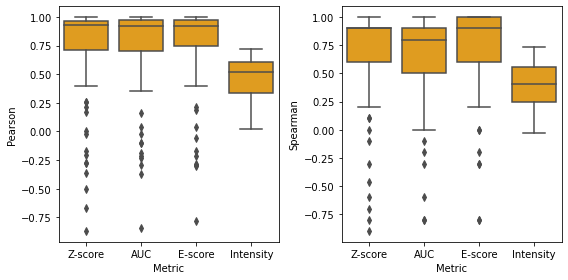

In [50]:
# Plot just the kipoi results as boxplots
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
sns.boxplot(data=pearson_kipoi_long, x="Metric", y="Pearson", color="orange", ax=ax[0])
sns.boxplot(data=spearman_kipoi_long, x="Metric", y="Spearman", color="orange", ax=ax[1])
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "correlation_boxplots_kipoi_10kmers_.pdf"))

In [52]:
pearson_kipoi_long.to_csv(os.path.join(eu.settings.output_dir, f"pearson_performance_{number_kmers}kmers_kipoi.tsv"), index=False, sep="\t")
spearman_kipoi_long.to_csv(os.path.join(eu.settings.output_dir, f"spearman_performance_{number_kmers}kmers_kipoi.tsv"), index=False, sep="\t")

---

# Scratch

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

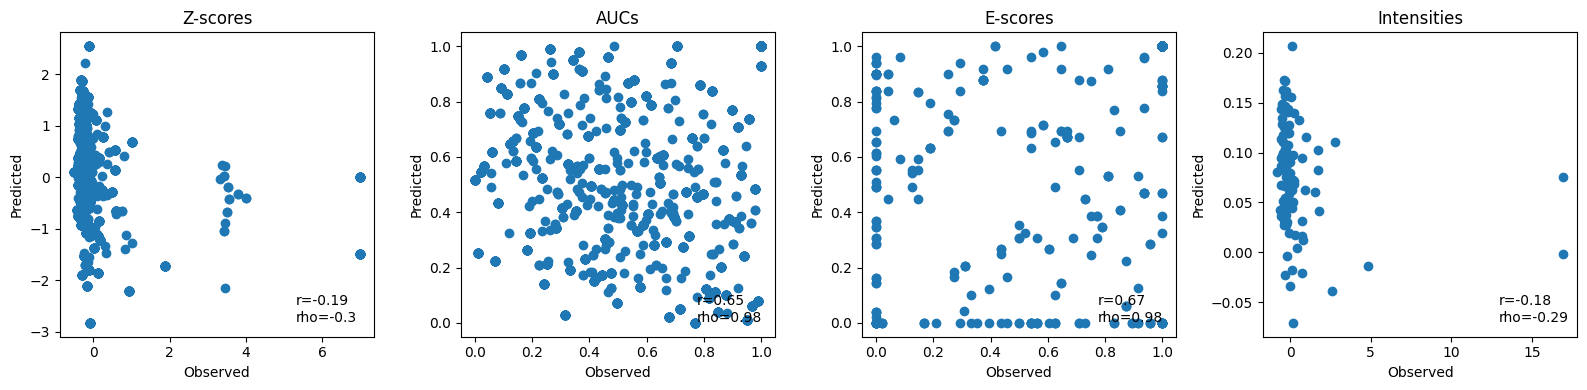

In [ ]:
eu.predict.column_rnac_metrics_apply(sdata_test, b_presence_absence, probe_id="RNCMPT00001", preds_suffix="_predictions_ST", use_calc_auc=True, verbose=True, n_kmers=100)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/vscode/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/vscode/.local/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/100 [00:00<?, ?it/s]

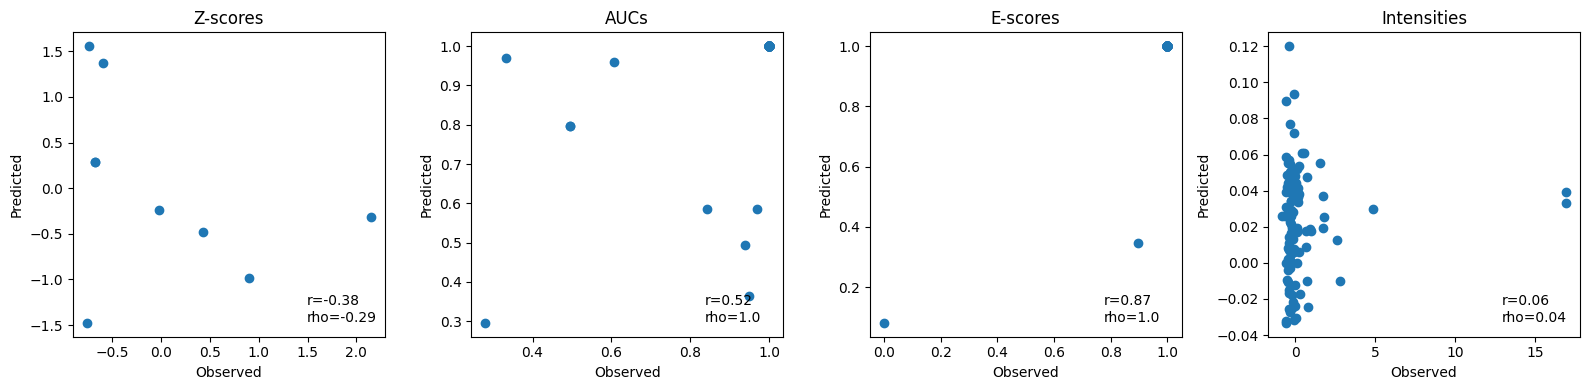

In [ ]:
eu.predict.column_rnac_metrics_apply(sdata_test, b_presence_absence, probe_id="RNCMPT00001", preds_suffix="_predictions_MT", use_calc_auc=True, verbose=True, n_kmers=100)